# **Load the dataset**

In [19]:
!pip install scikit-fuzzy

In [20]:
#  Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

#  Load the Dataset
df = pd.read_csv('merged_tomato_data.csv')
df.head()


,date,bengaluru_wholesaleprice,bengaluru_retailprice,bengaluru_volume,bengaluru_avg._temperature,bengaluru_rainfall,diesel_price,mumbai_retailprice,hyderabad_retailprice
0,2015-01-01,1295,1961,30762,20.8,9.0,60.70,3442,1529
1,2015-02-01,829,1392,11995,22.9,0.0,65.19,2826,1529
2,2015-03-01,776,1296,13511,25.5,37.7,63.30,2761,1529
3,2015-04-01,995,1640,8964,27.1,225.8,65.67,2563,1529
4,2015-05-01,2115,2888,11665,26.9,178.4,67.05,2680,1962


In [21]:
#  Explore and Clean the Data
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        187 non-null    object 
 1   bengaluru_wholesaleprice    187 non-null    int64  
 2   bengaluru_retailprice       187 non-null    int64  
 3   bengaluru_volume            187 non-null    int64  
 4   bengaluru_avg._temperature  187 non-null    float64
 5   bengaluru_rainfall          187 non-null    float64
 6   diesel_price                187 non-null    float64
 7   mumbai_retailprice          187 non-null    int64  
 8   hyderabad_retailprice       187 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 13.3+ KB


,0
date,0
bengaluru_wholesaleprice,0
bengaluru_retailprice,0
bengaluru_volume,0
bengaluru_avg._temperature,0
bengaluru_rainfall,0
diesel_price,0
mumbai_retailprice,0
hyderabad_retailprice,0


In [22]:
# Handle Missing Values
df = df.fillna(method='ffill')


/tmp/ipython-input-22-714855102.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


# **Feature-Target Split**

In [23]:
# Select Features for Clustering
features = df.drop(columns=['bengaluru_retailprice', 'date'])
target = df['bengaluru_retailprice']

# **Normalize Input Features**

In [24]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# **Apply Fuzzy C-Means Clustering**

In [25]:
# Number of Clusters
k = 3
# Maximum number of iterations
MAX_ITER = 100
# Number of data points
n = len(df)
# Fuzzy parameter
m = 1.7 #Select a value greater than 1 else it will be knn

In [26]:
n_clusters = 3
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    scaled_data.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None
)

# **Assign Cluster Labels to Each Data Point**

In [27]:
cluster_labels = np.argmax(u, axis=0)
df['Cluster'] = cluster_labels


# **Visualize Clusters**

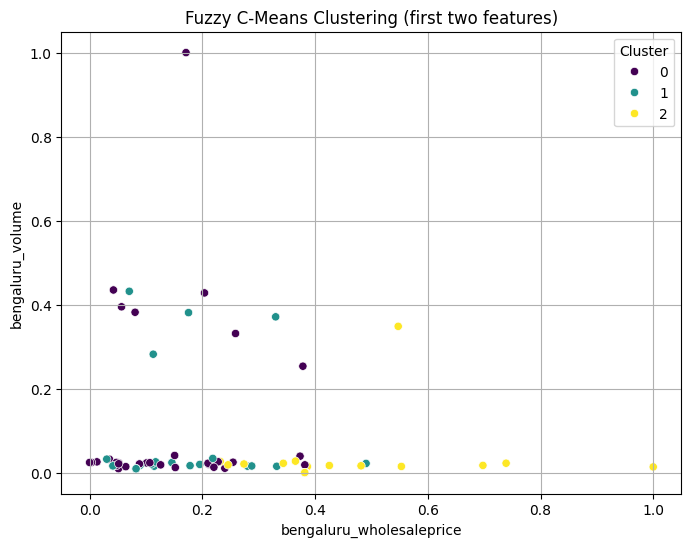

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=scaled_data[:, 0], y=scaled_data[:, 1], hue=cluster_labels, palette='viridis'
)
plt.title('Fuzzy C-Means Clustering (first two features)')
plt.xlabel(features.columns[0])
plt.ylabel(features.columns[1])
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# **Visualize Cluster Centers**

In [29]:
centers = scaler.inverse_transform(cntr)

for i, center in enumerate(centers):
    print(f"Cluster {i} Center:")
    for col, val in zip(features.columns, center):
        print(f"  {col}: {val:.2f}")
    print()


Cluster 0 Center:
  bengaluru_wholesaleprice: 1262.01
  bengaluru_volume: 3377.65
  bengaluru_avg._temperature: 22.36
  bengaluru_rainfall: 45.07
  diesel_price: 75.12
  mumbai_retailprice: 2742.05
  hyderabad_retailprice: 2409.95

Cluster 1 Center:
  bengaluru_wholesaleprice: 1262.08
  bengaluru_volume: 3006.54
  bengaluru_avg._temperature: 25.51
  bengaluru_rainfall: 92.16
  diesel_price: 77.60
  mumbai_retailprice: 2579.12
  hyderabad_retailprice: 2683.71

Cluster 2 Center:
  bengaluru_wholesaleprice: 2380.23
  bengaluru_volume: 470.87
  bengaluru_avg._temperature: 23.31
  bengaluru_rainfall: 157.54
  diesel_price: 94.08
  mumbai_retailprice: 5652.85
  hyderabad_retailprice: 6056.48



# **Visualize Membership Strength**

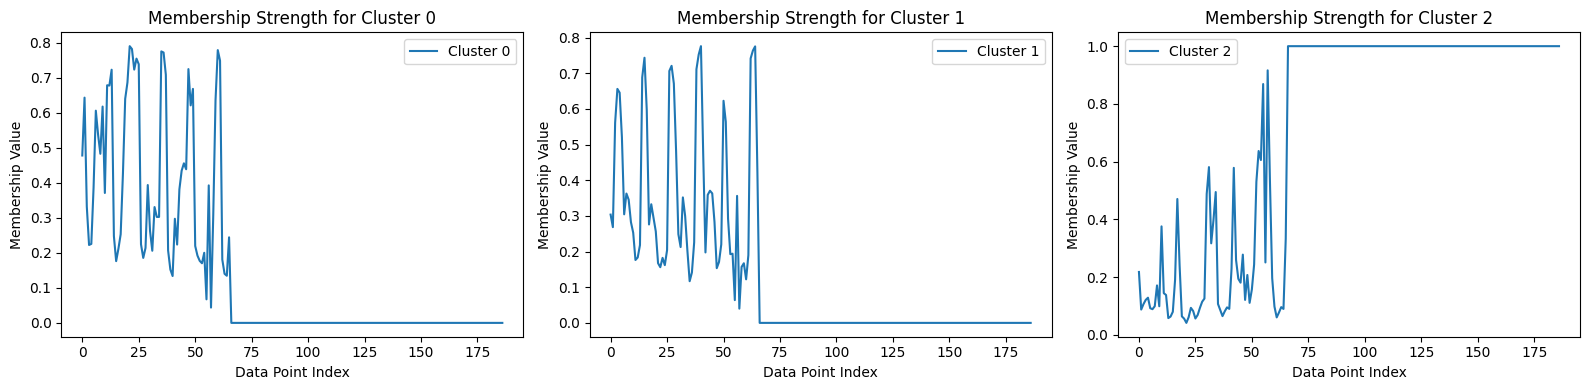

In [30]:
fig, axes = plt.subplots(1, n_clusters, figsize=(16, 4))
for i in range(n_clusters):
    axes[i].plot(u[i], label=f'Cluster {i}')
    axes[i].set_title(f'Membership Strength for Cluster {i}')
    axes[i].set_xlabel('Data Point Index')
    axes[i].set_ylabel('Membership Value')
    axes[i].legend()
plt.tight_layout()
plt.show()


# **Map Clusters to Estimated Prices**

In [31]:
#  Map each cluster to average 'bengaluru_retailprice'
cluster_price_map = df.groupby('Cluster')['bengaluru_retailprice'].mean().to_dict()
print("Cluster to Average Price Mapping:", cluster_price_map)

#  Predict price using cluster labels
df['predicted_price'] = df['Cluster'].map(cluster_price_map)

print("Cluster to Estimated Retail Price Mapping:")
for cluster, price in cluster_price_map.items():
    print(f"Cluster {cluster}: ₹{price:.2f}")

Cluster to Average Price Mapping: {0: 1876.7096774193549, 1: 1972.5, 2: 3621.902985074627}
Cluster to Estimated Retail Price Mapping:
Cluster 0: ₹1876.71
Cluster 1: ₹1972.50
Cluster 2: ₹3621.90


# **Predict Prices Using Cluster Mapping**

In [32]:
# Predict retail price for each sample based on its cluster label
y_pred = np.array([cluster_price_map[label] for label in cluster_labels])

# **Evaluate the Fuzzy Model**

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = df['bengaluru_retailprice']
y_pred = df['predicted_price']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f" MAE  = {mae:.2f}")
print(f" RMSE = {rmse:.2f}")
print(f" MAPE = {mape:.2f}%")


 MAE  = 289.04
 RMSE = 551.72
 MAPE = 13.02%


# **Visualize Actual vs Predicted Prices**

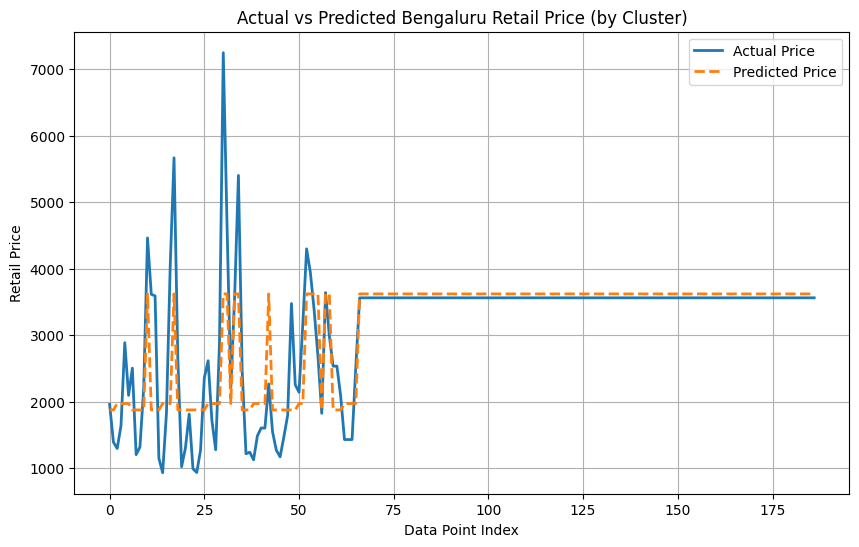

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(y_true.values, label='Actual Price', linewidth=2)
plt.plot(y_pred.values, label='Predicted Price', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Bengaluru Retail Price (by Cluster)")
plt.xlabel("Data Point Index")
plt.ylabel("Retail Price")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Get the most frequent cluster in recent months (using the last cluster label)
# Note: A more robust approach for 'recent months' might involve looking at the last few data points
most_recent_cluster = cluster_labels[-1]

# Get the predicted price based on the most recent cluster's average price
# This requires the cluster_price_map which is calculated in cell HohGkSGHQ-wH
if 'cluster_price_map' not in locals():
     print("Error: 'cluster_price_map' is not defined. Please ensure the cluster to price mapping step (cell HohGkSGHQ-wH) has been executed successfully.")
else:
    predicted_price = cluster_price_map[most_recent_cluster] # Use the mapped price

    # Generate next 10 month dates
    last_date = pd.to_datetime(df['date'].iloc[-1]) # Get the last date from the 'date' column and convert to datetime
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=1, freq='MS')

    # Assign the predicted price to all future months
    # For this simple forecast, we assume the price of the most recent cluster persists
    future_prices = pd.Series([predicted_price]*1, index=future_dates)

    # Create DataFrame
    forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_prices.values})
    print(forecast_df)

        Date  Predicted_Price
0 2020-08-01      3621.902985


# **Stream**

In [36]:
#  Install Required Libraries (run once)
!pip install -q ipywidgets scikit-fuzzy plotly

#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ipywidgets import interact, FileUpload, Dropdown, IntSlider, Output, VBox, Button
from IPython.display import display, clear_output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.2 MB/s eta 0:00:00


In [37]:
#  UI: File Uploader
upload = FileUpload(accept='.csv', multiple=False)
output = Output()

#  Callback when CSV is uploaded
def handle_upload(change):
    output.clear_output()
    with output:
        # Load CSV
        fname = list(upload.value.keys())[0]
        content = upload.value[fname]['content']
        with open(fname, 'wb') as f:
            f.write(content)
        df = pd.read_csv(fname)

        if 'bengaluru_retailprice' not in df.columns:
            print(" 'bengaluru_retailprice' column not found.")
            return

        print(" CSV loaded successfully!")
        display(df.head())  # Show raw data

        # Proceed to fuzzy logic dashboard
        fuzzy_dashboard(df)

upload.observe(handle_upload, names='value')
display(VBox([upload, output]))

#  Fuzzy Logic Dashboard
def fuzzy_dashboard(df):
    X = df.drop(columns=['bengaluru_retailprice'])

#  Remove non-numeric columns (like 'date')
    X = X.select_dtypes(include=[np.number])
    y = df['bengaluru_retailprice'].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    def run_fuzzy(n_clusters):
        clear_output(wait=True)

        # Clustering
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X_scaled.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000)

        cluster_labels = np.argmax(u, axis=0)
        cluster_prices = {i: y[cluster_labels == i].mean() for i in range(n_clusters)}
        y_pred = np.array([cluster_prices[label] for label in cluster_labels])

        # Metrics
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mape = np.mean(np.abs((y - y_pred) / y)) * 100

        # Show Metrics
        print(f"Clusters: {n_clusters}")
        print(f"MAE  = {mae:.2f}")
        print(f"RMSE = {rmse:.2f}")
        print(f"MAPE = {mape:.2f}%")

        # Plot: Actual vs Predicted
        fig1 = go.Figure()
        fig1.add_trace(go.Scatter(y=y, mode='lines', name='Actual Price'))
        fig1.add_trace(go.Scatter(y=y_pred, mode='lines', name='Predicted Price'))
        fig1.update_layout(title='Actual vs Predicted Retail Price', xaxis_title='Sample Index', yaxis_title='Price')
        fig1.show()

        # Plot: Membership Strength
        fig2 = go.Figure()
        for i in range(n_clusters):
            fig2.add_trace(go.Scatter(y=u[i], mode='lines', name=f'Membership to Cluster {i}'))
        fig2.update_layout(title='Fuzzy Membership Strength per Cluster', xaxis_title='Sample Index', yaxis_title='Membership Degree')
        fig2.show()

        # Optional: Show cluster center values
        print("\n Cluster → Estimated Retail Price Mapping:")
        for i in range(n_clusters):
            print(f"Cluster {i}: ₹{cluster_prices[i]:.2f}")

    interact(run_fuzzy, n_clusters=IntSlider(min=2, max=6, step=1, value=3))


# **comparison to research paper**